In [21]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pytesseract
from PIL import Image

In [22]:
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'  # Specifica il percorso di Tesseract

In [23]:

# Open the image file
image = Image.open('data\scientific_publication\doc_000128.png')

# Perform OCR using PyTesseract
text = pytesseract.image_to_string(image)

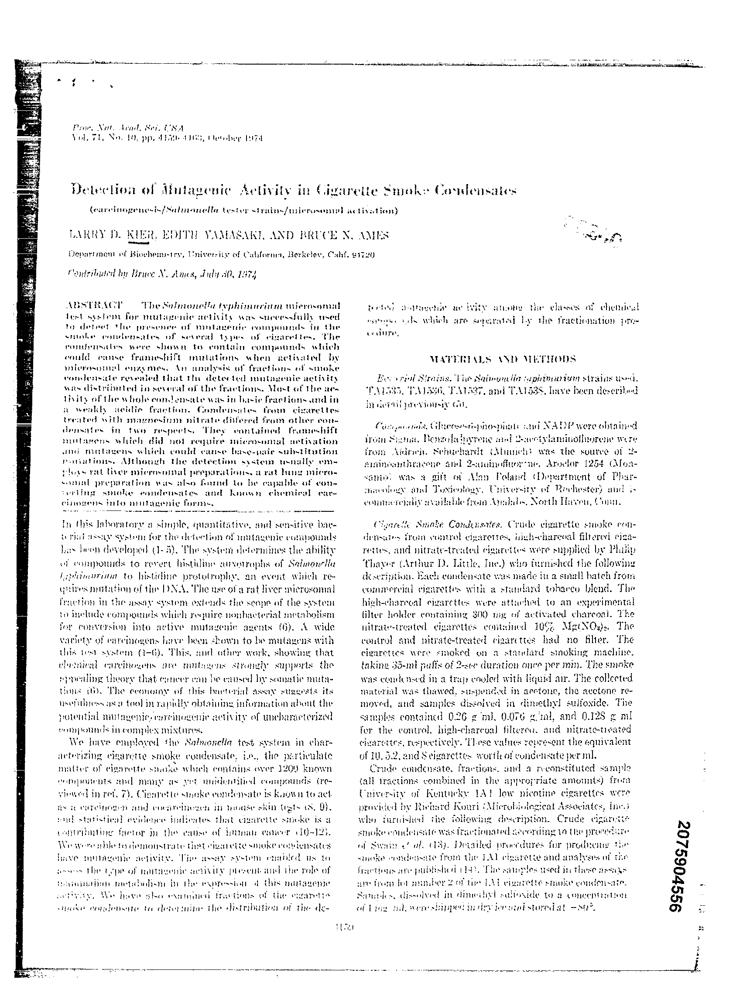

In [24]:
image

In [27]:
print(text)

Detction of Mutagenic Activity in ¢

(raretnnene

Satinoneltetetor tt

Poneto Brae N- Ames, di 3, 1995
ABSERAGE The Sotmonet typhimneinion wiersennsh
et ss ittsgeie titty wae seven, ed
state ites of seseeal tyes A the
‘romfonsates more chain to rant ae hier
« Trameshite asm cant by

su gral

‘ete te
‘ihe fraction

cei

In he baton
1 of ase eeu

al moa lem

Juss eon ovelopl (1-5) The spat sleternsine the ability
onpostids to sovert ean of Salona
Jahinarinn to istatine prototraphy. an event hil Re
ach of te DNS, "The use oF eat Hive iezeomal

Fron nthe ss’ epstm estas the senpe af the astern
Jnotuds woropestivs which rere wouhaet shetty
for eunveasion into active munaeaie agente (6). wide

ate of ravinegens fave bovn newith
ssatean (et), ‘This, ai athe wonky shoring that
usairad avis one noua steely xupprte the
ing oe that ere canbe earl st
The erin of thie Foster st ot

oon rps tun rmtin a

ypotutial mutagenie-rsrciuaasnie aot ity of unebaratevized

any sms in cope ste
We ave esuplosed 

In [26]:


data_path = ""
categories = os.listdir(data_path)
num_classes = len(categories)


X = []
y = []


for category_id, category in enumerate(categories):
    category_path = os.path.join(data_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))  # Ridimensionamento delle immagini a dimensioni uniformi
        X.append(img)
        y.append(category_id)


X = np.array(X) / 255.0  # Normalizzazione dei valori dei pixel tra 0 e 1

# Conversione delle etichette in formato one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensioni del set di addestramento:", X_train.shape, y_train.shape)
print("Dimensioni del set di test:", X_test.shape, y_test.shape)




FileNotFoundError: [WinError 3] The system cannot find the path specified: ''